In [1]:
import sys
import matplotlib.pyplot as plt
import os
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE
from lib import data_prep, feature_extraction, models
from sklearn.utils import shuffle
import numpy as np

# Loading the data
- Plotting

In [2]:
# Base directory
data_loc = os.path.join(os.getcwd(), "DATA")

# file name
file_names = {
    0: "machine_OFF_no-error.csv",  # When the machine was turned off at the controller
    1: "machine_ON_no-ref_start-error_1.csv",  # Machine turned ON, and the parameter switch enable error
    2: "machine_ON_no-ref_start-error_2.csv",
    3: "machine_ON_ref_no-error.csv",  # Machine ON referenced and no-error idling
    4: "machine_ON_ref_overtravel-error_x_neg.csv",  # Machine ON referenced and Overtravel for X negative
    5: "machine_ON_ref_overtravel-error_x_pos.csv",  # Machine ON referenced and Overtravel for X positive
    6: "machine_ON_ref_overtravel-error_y_neg.csv",  # Machine ON referenced and Overtravel for Y negative
    7: "machine_ON_ref_overtravel-error_y_pos.csv",  # Machine ON referenced and Overtravel for Y positive
    8: "machine_ON_ref_overtravel-error_z_neg.csv",  # Machine ON referenced and Overtravel for Z negative
}

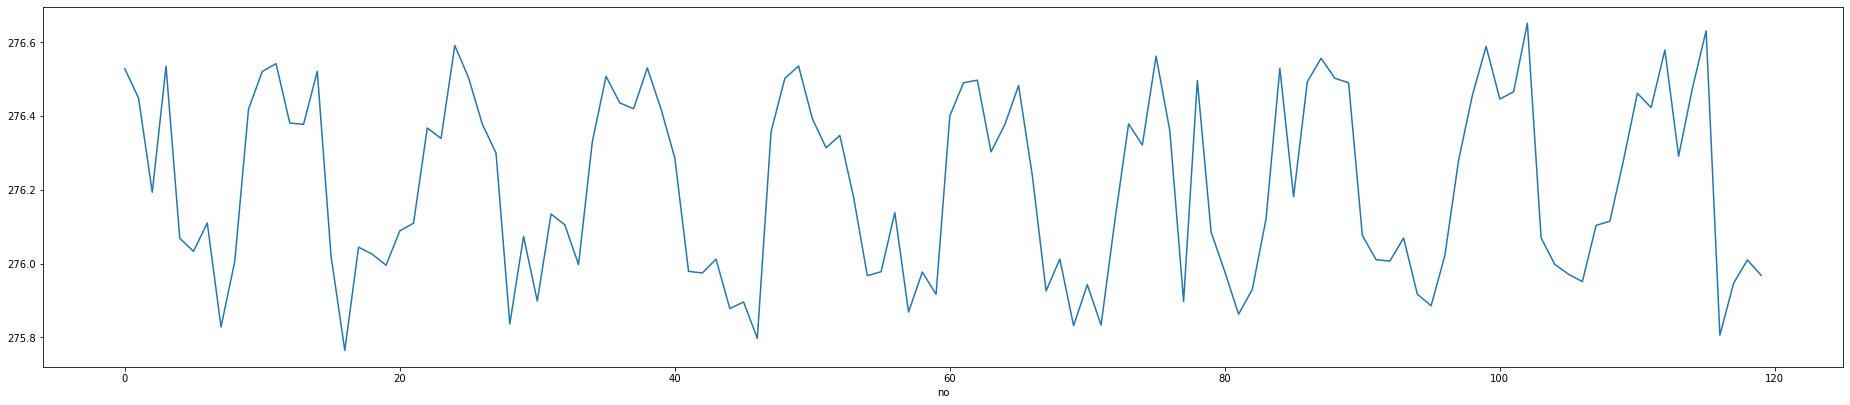

In [3]:
# load the data
index = 6
df = pd.read_csv(os.path.join(data_loc, file_names[index]), header="infer", index_col="no")
fig = plt.figure(figsize=(25, 5))
axs = fig.add_axes([0, 0, 1, 1])
df["PowerSum"][0:120].plot(ax=axs)

# Data preparation

- Control on segment lengths

## Segmentation

- Control different segmentation length
    - 2 mins

In [4]:
segment_secs = 120

In [5]:
# Dont choose "no" and "sample_time" as they will be added later to the beginning
# Chosen - Three different power components for three phases
chosen_cols = ["Power1", "Power2", "Power3", "PowerReac1", "PowerReac2", "PowerReac3", "PowerApp1", "PowerApp2", "PowerApp3"]
segmented_data = {}
for index, file_name in file_names.items():
    path = os.path.join(data_loc, file_name)
    temp = data_prep.segment_data(file_name=path, col_names=chosen_cols, segment_secs=segment_secs)
    # Remove the sample_time col
    temp = temp[:, 1:, :]
    segmented_data[file_name] =  temp

In [6]:
# Print to ensure that segmentation is successful
for file_name in segmented_data.keys():

    sys.stdout.write(f"For the file-{file_name} the shape-{segmented_data[file_name].shape}\n")

For the file-machine_OFF_no-error.csv the shape-(120, 9, 57)
For the file-machine_ON_no-ref_start-error_1.csv the shape-(120, 9, 9)
For the file-machine_ON_no-ref_start-error_2.csv the shape-(120, 9, 53)
For the file-machine_ON_ref_no-error.csv the shape-(120, 9, 121)
For the file-machine_ON_ref_overtravel-error_x_neg.csv the shape-(120, 9, 346)
For the file-machine_ON_ref_overtravel-error_x_pos.csv the shape-(120, 9, 147)
For the file-machine_ON_ref_overtravel-error_y_neg.csv the shape-(120, 9, 442)
For the file-machine_ON_ref_overtravel-error_y_pos.csv the shape-(120, 9, 141)
For the file-machine_ON_ref_overtravel-error_z_neg.csv the shape-(120, 9, 307)


## Determine classes

Make a choice on the number of classes used for the study

In [7]:
# Associations between the classes and the files in this study
class_file_association = {
    "normal": ["machine_ON_ref_no-error.csv", "machine_OFF_no-error.csv"],
    "error": ["machine_ON_ref_overtravel-error_x_neg.csv", "machine_ON_ref_overtravel-error_x_pos.csv", "machine_ON_no-ref_start-error_1.csv", "machine_ON_no-ref_start-error_2.csv", "machine_ON_ref_overtravel-error_y_neg.csv", "machine_ON_ref_overtravel-error_y_pos.csv", "machine_ON_ref_overtravel-error_z_neg.csv"]
}

In [8]:
class_segmented_data = {}
for class_instance in class_file_association.keys():
    for index, file_name in enumerate(class_file_association[class_instance]):

        if index == 0:
            class_segmented_data[class_instance] = segmented_data[file_name]
        else:
            class_segmented_data[class_instance] = np.append(class_segmented_data[class_instance], segmented_data[file_name], axis=-1)

In [9]:
# Reshape the data appropriately
for class_instance in class_segmented_data.keys():
    class_segmented_data[class_instance] = np.transpose(class_segmented_data[class_instance], (2, 1, 0))

In [10]:
# Print to ensure that the files have been loaded correctly
for class_instance in class_segmented_data.keys():

    sys.stdout.write(f"The class-{class_instance} has the shape-{class_segmented_data[class_instance].shape}\n")

The class-normal has the shape-(178, 9, 120)
The class-error has the shape-(1445, 9, 120)


## Feature Extraction

- Time domain
- Frequency domain
- Time-frequency domain

In [11]:
class_dataset_features = {}
for class_instance in class_segmented_data.keys():
    dataset_features = []
    for row in class_segmented_data[class_instance]:
        computed_features = []
        for col in row:
            freq_args = [{"axis": 0}, {"axis": 0}, {"axis": 0, "nperseg": 60}]
            freq_time_args = [{"wavelet": "db1"}, {"wavelet": "db1"}, {"wavelet": "db1"}]
            computed_features += feature_extraction.compute_all_features(col, freq_args=freq_args, freq_time_args=freq_time_args)

        # Append to a list
        dataset_features.append(computed_features)

    # Add to class instance
    class_dataset_features[class_instance] = np.array(dataset_features)

In [12]:
sys.stdout.write("After feature extraction process\n\n")
for class_instance in class_dataset_features.keys():

    sys.stdout.write(f'For the class-{class_instance} , the extracted features has the shape={class_dataset_features[class_instance].shape}\n')

After feature extraction process

For the class-normal , the extracted features has the shape=(178, 153)
For the class-error , the extracted features has the shape=(1445, 153)


## Generate training data

- Combine all with appropriate labels
- Using KFold

In [13]:
class_label_associations = {
    "normal": 0,
    "error": 1,
}
for index, class_instance in enumerate(class_dataset_features.keys()):

    temp_X = class_dataset_features[class_instance]
    temp_y = np.repeat(class_label_associations[class_instance], temp_X.shape[0])[:, np.newaxis]

    if index == 0:
        X = temp_X
        y = temp_y
    else:
        X = np.append(X, temp_X, axis=0)
        y = np.append(y, temp_y, axis=0)

# Shuffle the dataset
X, y = shuffle(X, y, random_state=42)
# To a vector format
y =  np.squeeze(y)

sys.stdout.write(f"The final combined shape-{X.shape}\n")

The final combined shape-(1623, 153)


## Oversample the data (if required)

There are different techniques that are available for over-sampling
- SMOTE
- RandomOversampling
- ADASYN

In [14]:
oversampling_required = True

# Current count
sys.stdout.write(f"Without resampling -> {Counter(y)}\n")

if oversampling_required:
    sm = SMOTE(sampling_strategy="minority", random_state=42, n_jobs=8)
    X, y = sm.fit_resample(X, y)

    # Get the resampled final count
    sys.stdout.write(f"After resampling -> {Counter(y)}\n")
    X, y = shuffle(X, y, random_state=52)

Without resampling -> Counter({1: 1445, 0: 178})
After resampling -> Counter({0: 1445, 1: 1445})


# Model development
- Choose among the available models
- Set the parameters appropriately
- Train the model and get the metrics

## CV Fold training

- Training across 10-fold CV

In [15]:
model_params = {
    "LogisticRegression" : {"class_weight": "balanced", "max_iter": 5000, "n_jobs": 4},
    "DecisionTreeClassifier": {"min_samples_split": 100},
    "KNeighborsClassifier": {"n_neighbors": 10},
    "SVC": {"kernel": "rbf", "tol":1e-7},
    "BaggingClassifier": {"n_estimators": 50},
    "RandomForestClassifier": {"n_estimators": 100, "min_samples_split": 100, "class_weight": "balanced"},
}

In [16]:
# Create repo of models
models_repo = models.Models()
# Initialize the models
models_repo.create_models(model_params)

# 10-fold to determine the effective performance of all models\
cv_results_summary = models_repo.train_models_cvfolds(X, y, kfolds=10,  summarize_results=True)

In [24]:
# Print the required dataframe and record the metrics
cv_results_summary["RandomForestClassifier"]

,average,std,min,max,count
accuracy_score,1.0,0.0,1.0,1.0,10
balanced_accuracy_score,1.0,0.0,1.0,1.0,10
f1_score,1.0,0.0,1.0,1.0,10
recall_score,1.0,0.0,1.0,1.0,10
precision_score,1.0,0.0,1.0,1.0,10
